In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina' 
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import gseapy as gp
from matplotlib import pyplot as plt
from tqdm import tqdm
import requests

In [ ]:
inputExcelPath = "sigX_data.xlsx"

rawUpDF = pd.read_excel(inputExcelPath, sheet_name = "Increased in PAOSX")[["Locus tag", "Gene name", "Fold change", "T statistic", "P-value"]]
rawDownDF = pd.read_excel(inputExcelPath, sheet_name = "Decreased in PAOSX")[["Locus tag", "Gene name", "Fold change", "T statistic", "P-value"]]

backgroundPAO1 = pd.read_csv("PAO1_Conversion_df.csv")["Locus Tag"].to_list()

In [20]:
enr = gp.enrich(
    gene_list = rawUpDF["Locus tag"].to_list(),
    gene_sets = "pae_kegg_pathways.gmt",
    background = backgroundPAO1,
    outdir = None,
    verbose = True
    )

enrOut = enr.results

2025-06-12 16:09:47,126 [INFO] User defined gene sets is given: pae_kegg_pathways.gmt
2025-06-12 16:09:47,130 [INFO] Run: pae_kegg_pathways.gmt 
2025-06-12 16:09:47,137 [INFO] Done.


In [ ]:
pathway_ids = enr.results["Term"].to_list()

# Dictionary to store mapping
pathway2desc = {}

for pid in tqdm(pathway_ids):
    url = f"http://rest.kegg.jp/get/{pid}"
    res = requests.get(url)
    for line in res.text.splitlines():
        if line.startswith("NAME"):
            # Extract the descriptive title
            pathway2desc[pid] = line.replace("NAME", "").strip().replace(" - Pseudomonas aeruginosa PAO1", "")
            break

In [53]:
enrOut['PathName'] = enrOut['Term'].map(pathway2desc)

In [54]:
sigOut = enrOut.loc[enrOut["Adjusted P-value"] <= 0.05].sort_values(by = "Adjusted P-value")
sigOut["Term"] = sigOut["PathName"]
sigOut["Combined Score"] = sigOut["Combined Score"].apply(lambda x: np.log10(x) if x > 0 else 0)

Text(0.5, 0, 'log10(Combined Score)')

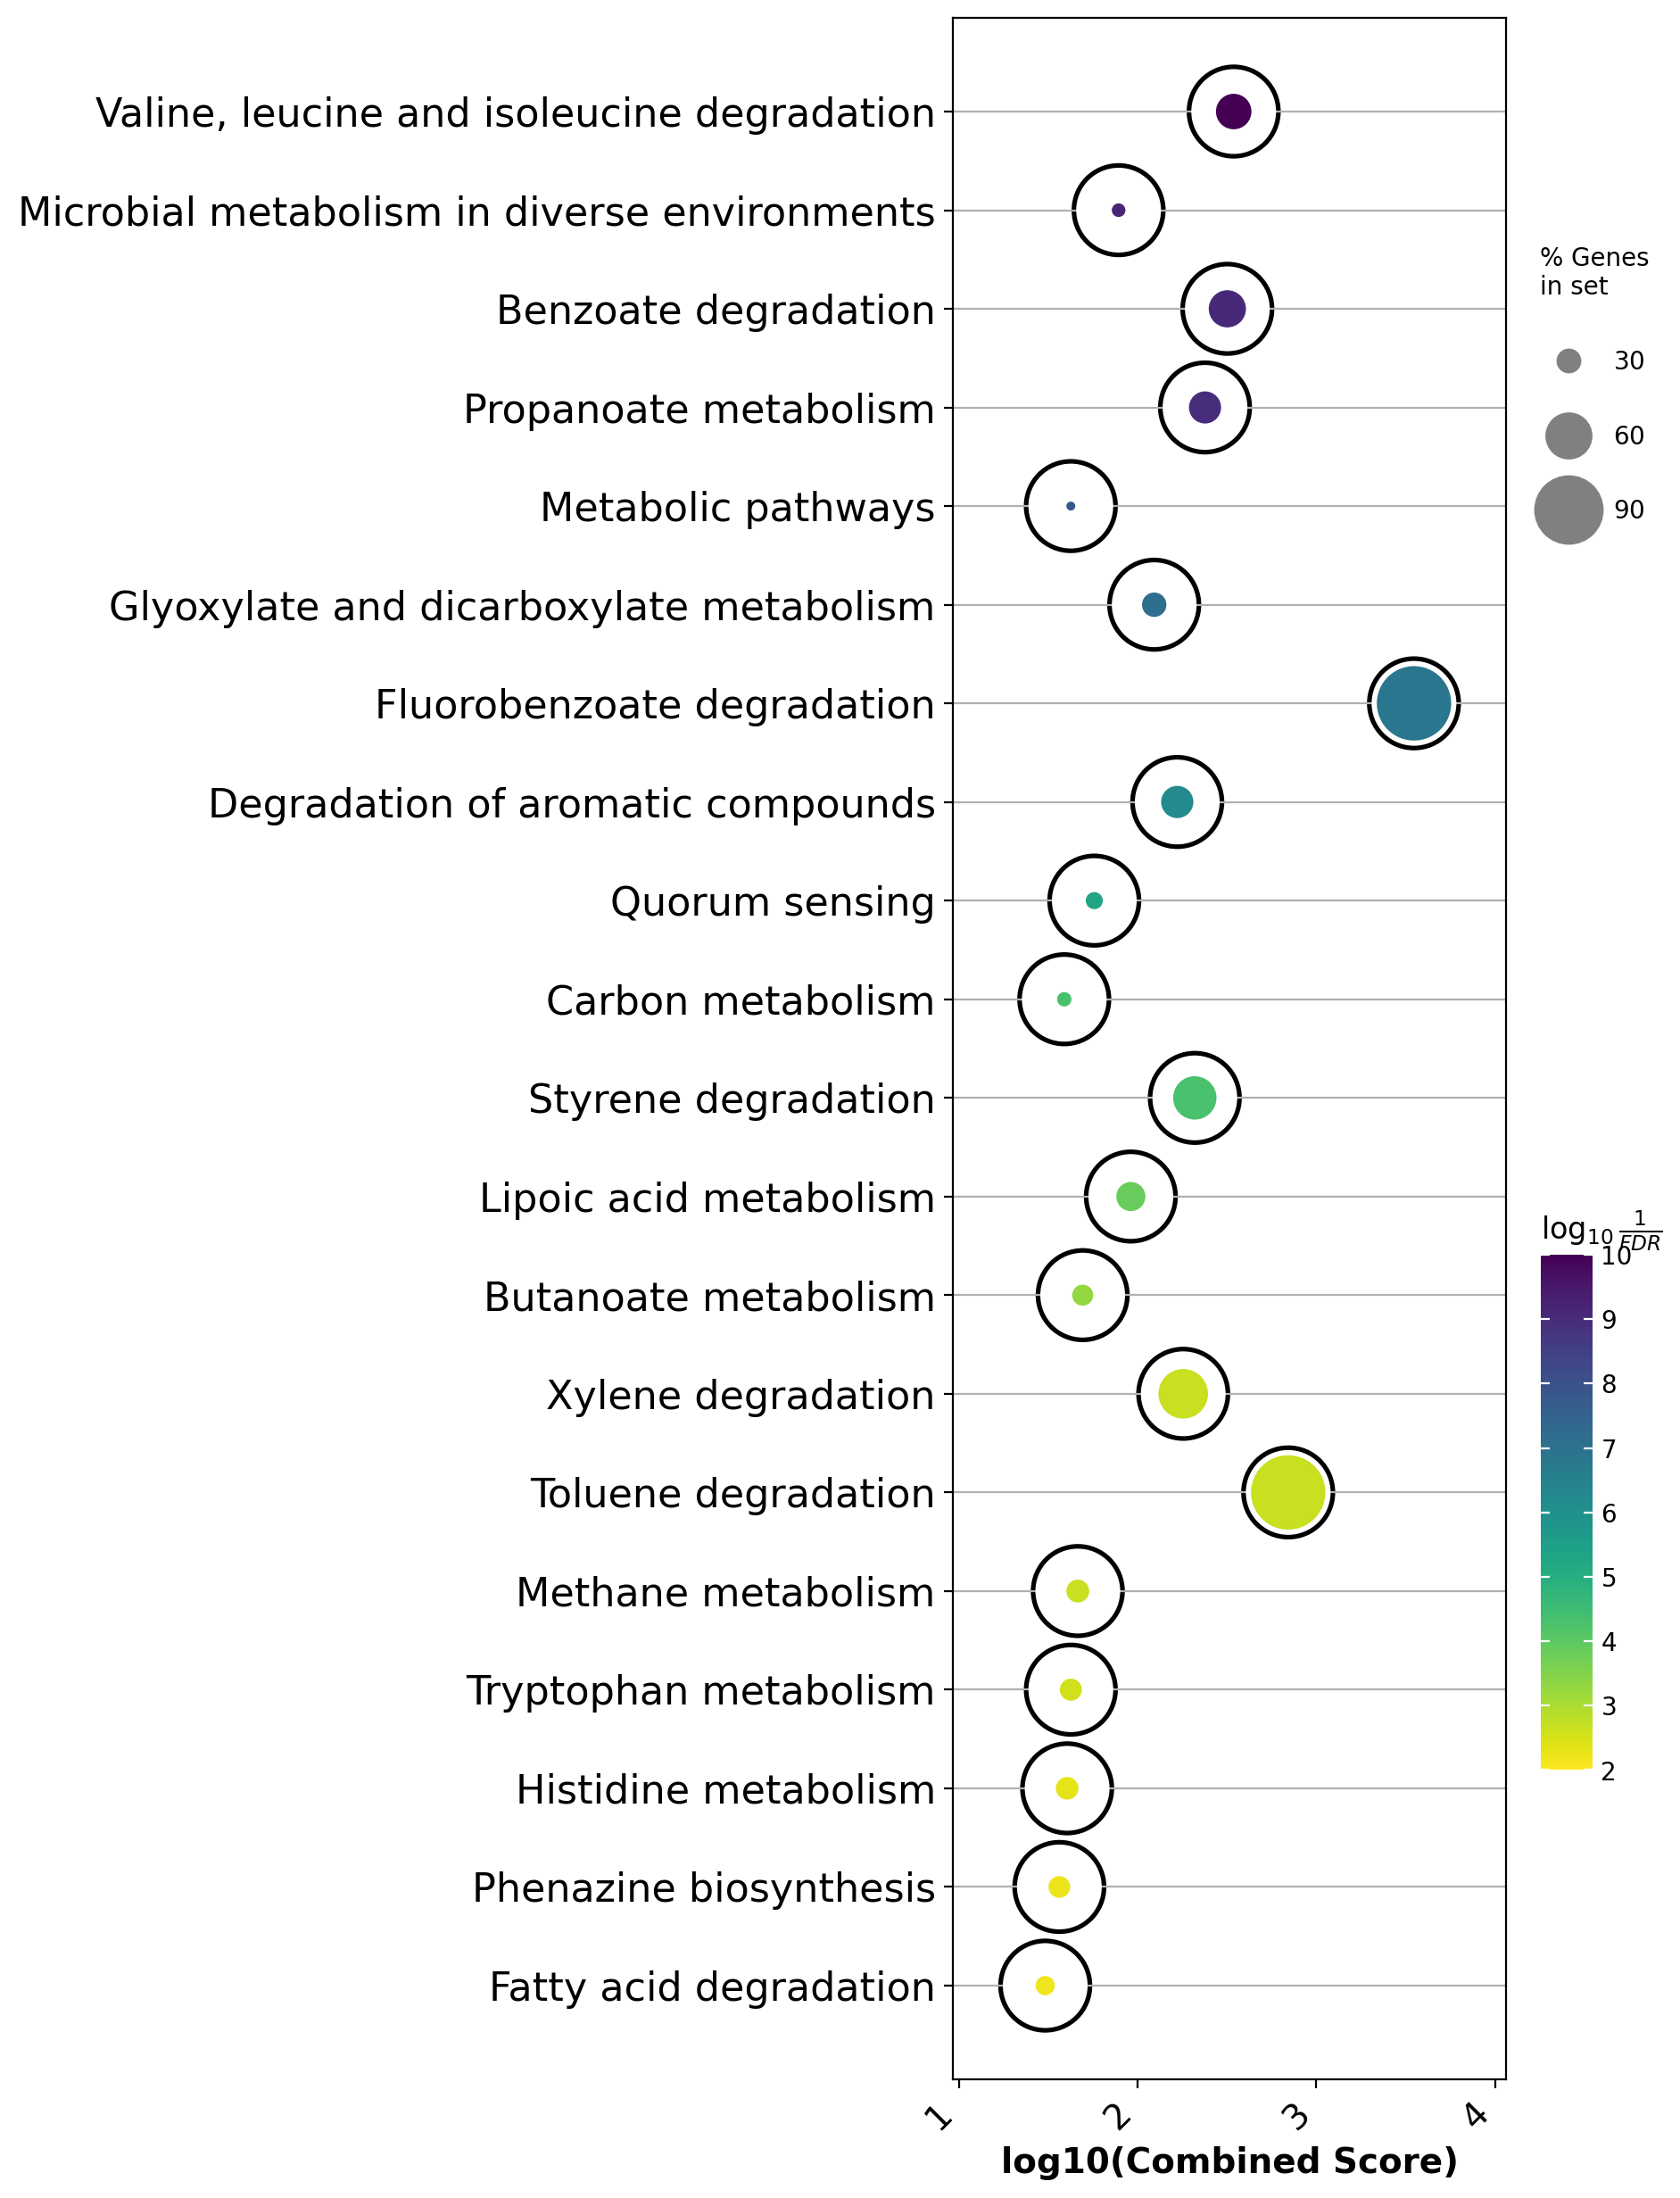

In [58]:
from gseapy import barplot, dotplot

dotInputDf = sigOut.copy().head(20)

ax = dotplot(dotInputDf,
             hue = "Adjusted P-value",
             y_order = dotInputDf["Term"].tolist()[::-1],
             x = None,
             top_term = 20,
             figsize = (5,15),
             xticklabels_rot = 45,
             show_ring = True,
             marker = 'o'
             )
ax.set_xlabel("log10(Combined Score)")  # <-- Add this line


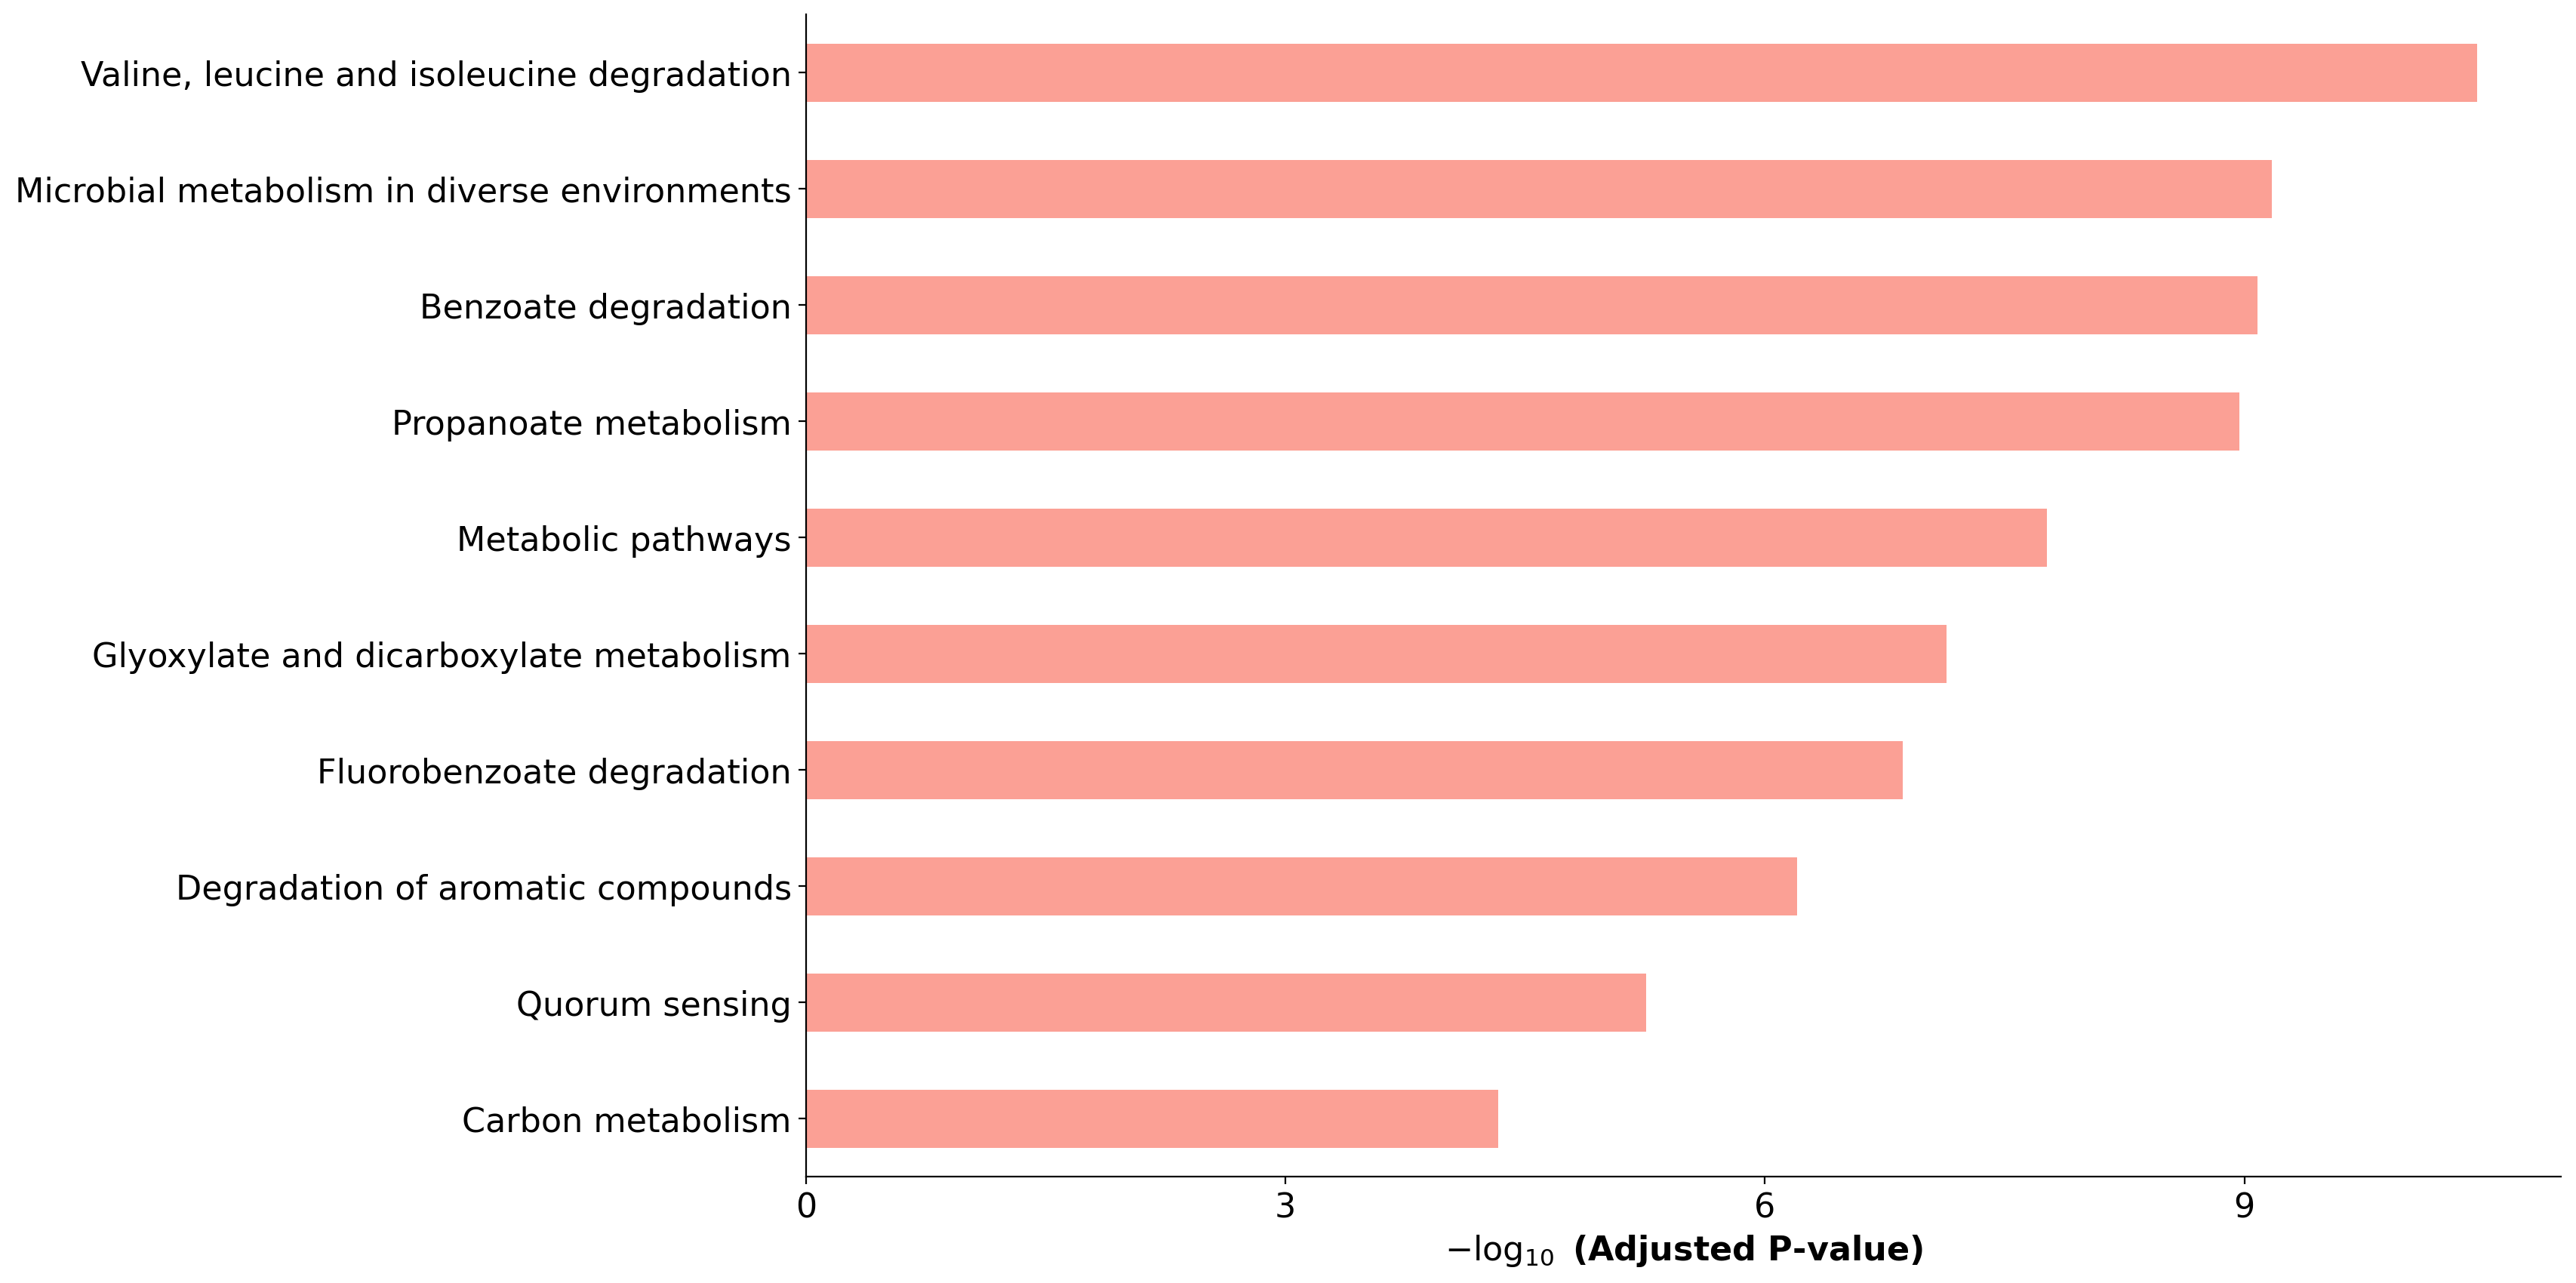

In [ ]:
ax = barplot(sigOut,
             column = "Adjusted P-value",
             top_term = 10,
             figsize=(10,10),
             hue = "Overlap"
             )